In [1]:
# Student Performance Analysis

# Team 43
# Aditya Rallapalli · Kruthika Suresh · Mitali Kamal Bagadia · Sharan Kumar Varma Chekuri ·
# Spring 2025

In [2]:
# 1.Introduction

# Context & Objective
# Understanding drivers of student success helps target educational support. We analyze 1,000 U.S. high-school records to answer: How does parental education affect math, reading, and writing performance?

# Main Hypothesis :  Students with parents who have a higher level of education tend to score higher in math, reading, and writing compared to those whose parents have lower education levels.
# sub Hypothesiss
# H1: Children of parents with a master’s degree outperform those whose parents have only a high-school diploma.
# H2: The parental-education effect is stronger for reading & writing than for math.
# H3: There is a significant performance gap between children of college-educated (associate’s/bachelor’s/master’s) vs non-college (some high school/high school) parents.

# Notebook Roadmap
#21. Setup & Data Loading
#32. Basic Checks & Descriptive Statistics
#43. Advanced Exploratory Visualizations
#54. Socioeconomic Association (Lunch vs Education)
#65. Hypothesis Testing (H1, H2, H3)
#76. Regression Modeling & Diagnostics
#87. Conclusions & References

In [3]:
# 2. Setup & Data Loading

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats import chi2_contingency, f_oneway, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load and sanitize
df = pd.read_csv('/content/drive/MyDrive/StudentsPerformance.csv')
df.columns = (df.columns.str.strip().str.lower()
              .str.replace(' ', '_', regex=False)
              .str.replace('/', '_', regex=False)
              .str.replace("'", "", regex=False)
              .str.replace('-', '_', regex=False))
for col in df.select_dtypes(include=['object']).columns:
    df[col] = (df[col].str.strip().str.lower()
               .str.replace(' ', '_', regex=False)
               .str.replace('/', '_', regex=False)
               .str.replace("'", "", regex=False)
               .str.replace('-', '_', regex=False))

In [8]:
# 3. Basic Checks & Descriptive Statistics

In [9]:
print("Shape:", df.shape)
print("\nData types & missing values:\n", df.dtypes, "\n", df.isnull().sum())
print("\nNumeric summary:")
display(df[['math_score','reading_score','writing_score']].describe().T)

Shape: (1000, 8)

Data types & missing values:
 gender                         object
race_ethnicity                 object
parental_level_of_education    object
lunch                          object
test_preparation_course        object
math_score                      int64
reading_score                   int64
writing_score                   int64
dtype: object 
 gender                         0
race_ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
dtype: int64

Numeric summary:


,count,mean,std,min,25%,50%,75%,max
math_score,1000.0,66.089,15.163080,0.0,57.00,66.0,77.0,100.0
reading_score,1000.0,69.169,14.600192,17.0,59.00,70.0,79.0,100.0
writing_score,1000.0,68.054,15.195657,10.0,57.75,69.0,79.0,100.0


In [10]:
# Interpretation: 1,000 rows; no missing values; scores range 0–100 with typical school-age distributions.

In [11]:
# 4. Advanced Exploratory Visualizations

In [12]:
# 4.1 Score Distributions by Parental Education

In [13]:
edu_order = [
    'some_high_school', 'high_school', 'associates_degree',
    'bachelors_degree', 'masters_degree'
]

# 4.1a Math Score
fig = px.violin(
    df,
    x='parental_level_of_education',
    y='math_score',
    color='parental_level_of_education',
    category_orders={'parental_level_of_education': edu_order},
    box=True,
    points='all',
    title='Math Score Distribution by Parental Education',
    labels={
        'parental_level_of_education': 'Parental Education',
        'math_score': 'Math Score'
    }
)
fig.update_traces(hovertemplate='Education Level: %{x}<br>Score: %{y}')
fig.update_layout(showlegend=False)
fig.show()

# 4.1b Reading Score
fig = px.violin(
    df,
    x='parental_level_of_education',
    y='reading_score',
    color='parental_level_of_education',
    category_orders={'parental_level_of_education': edu_order},
    box=True,
    points='all',
    title='Reading Score Distribution by Parental Education',
    labels={
        'parental_level_of_education': 'Parental Education',
        'reading_score': 'Reading Score'
    }
)
fig.update_traces(hovertemplate='Education Level: %{x}<br>Score: %{y}')
fig.update_layout(showlegend=False)
fig.show()


# 4.1c Writing Score
fig = px.violin(
    df,
    x='parental_level_of_education',
    y='writing_score',
    color='parental_level_of_education',
    category_orders={'parental_level_of_education': edu_order},
    box=True,
    points='all',
    title='Writing Score Distribution by Parental Education',
    labels={
        'parental_level_of_education': 'Parental Education',
        'writing_score': 'Writing Score'
    }
)
fig.update_traces(hovertemplate='Education Level: %{x}<br>Score: %{y}')
fig.update_layout(showlegend=False)
fig.show()

In [14]:
# Interpretation: Higher parental education levels are associated with progressively higher student scores—with writing showing the largest median increase, followed by reading and then math.

In [15]:
# 4.2 Interactive Scatter-Matrix of Scores

In [16]:
fig = px.scatter_matrix(
    df,
    dimensions=['math_score', 'reading_score', 'writing_score'],
    color='parental_level_of_education',
    symbol='parental_level_of_education',
    title='Pairwise Score Relationships by Parental Education',
    labels={c: c.replace('_',' ').title() for c in df.columns},
    category_orders={'parental_level_of_education': [
        'some_high_school', 'high_school', 'associates_degree',
        'bachelors_degree', 'masters_degree'
    ]},
    width=900,
    height=900
)

fig.update_traces(
    diagonal_visible=False,
    marker=dict(size=4, opacity=0.7)
)

fig.update_layout(
    margin=dict(l=50, r=200, t=80, b=50),
    legend=dict(
        title='Parental Education',
        x=1.15,
        y=0.5,
        traceorder="normal",
        bgcolor='rgba(255,255,255,0.8)'
    )
)

fig.show()

In [17]:
# Interpretation: Hover to inspect individual points; clusters shift upward with education.

In [18]:
# 4.3 Faceted trendline analysis quantifying Reading vs Writing, Reading vs Math, Math vs Writing with slopes and R²

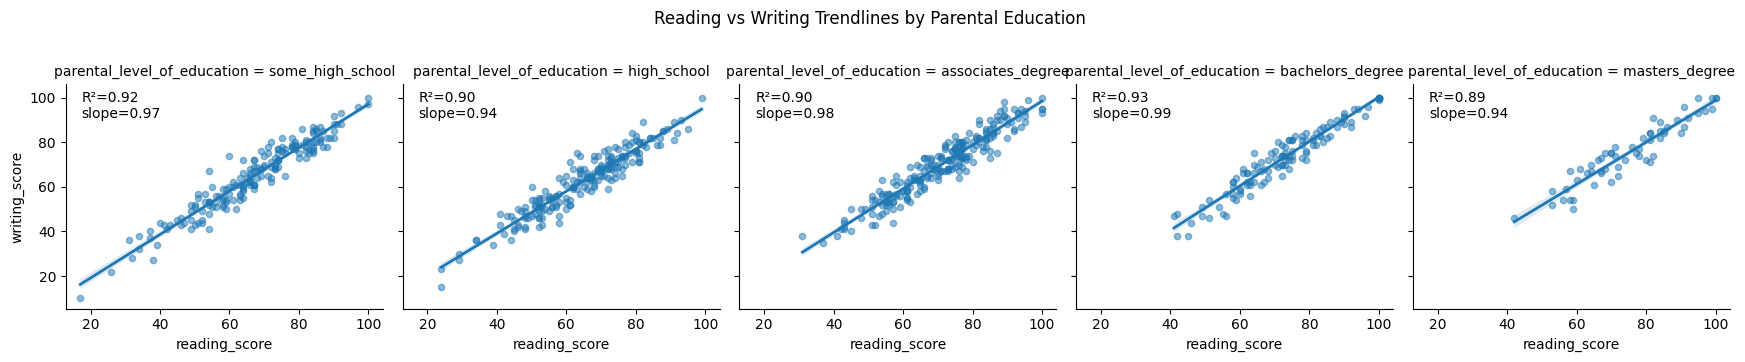

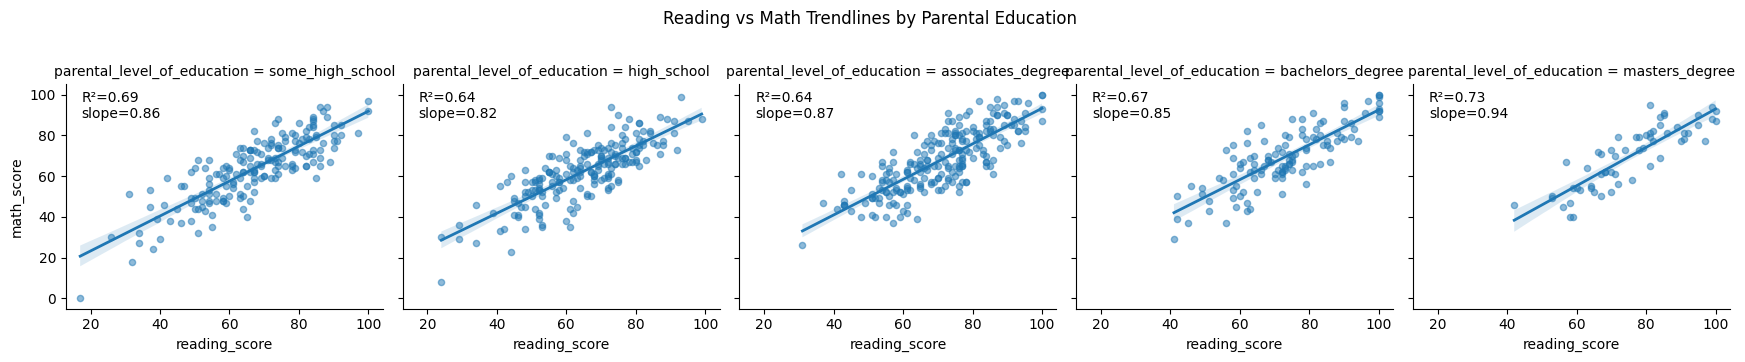

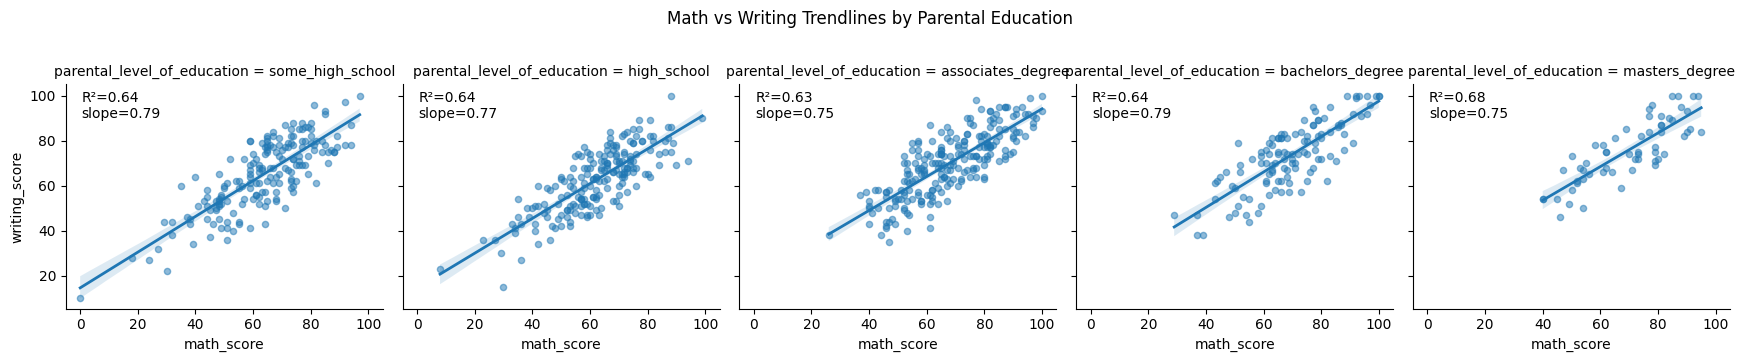

In [19]:
edu_order = ['some_high_school','high_school','associates_degree',
             'bachelors_degree','masters_degree']

# 4.3.1 Reading vs Writing
g = sns.lmplot(
    data=df, x="reading_score", y="writing_score",
    col="parental_level_of_education", col_order=edu_order,
    height=3.5, aspect=1, scatter_kws={"s":20,"alpha":0.5},
    line_kws={"linewidth":2}
)
for ax, lvl in zip(g.axes.flat, edu_order):
    res = smf.ols("writing_score ~ reading_score", data=df[df.parental_level_of_education==lvl]).fit()
    ax.text(0.05, 0.85, f"R²={res.rsquared:.2f}\nslope={res.params.reading_score:.2f}",
            transform=ax.transAxes)
g.fig.suptitle("Reading vs Writing Trendlines by Parental Education", y=1.02)
plt.tight_layout()

# 4.3.2 Reading vs Math Trendlines by Parental Education
g = sns.lmplot(
    data=df,
    x="reading_score", y="math_score",
    col="parental_level_of_education",
    col_order=edu_order,
    height=3.5, aspect=1,
    scatter_kws={"s":20, "alpha":0.5},
    line_kws={"linewidth":2}
)
for ax, lvl in zip(g.axes.flat, edu_order):
    res = smf.ols("math_score ~ reading_score",
                  data=df[df.parental_level_of_education==lvl]).fit()
    ax.text(
        0.05, 0.85,
        f"R²={res.rsquared:.2f}\nslope={res.params.reading_score:.2f}",
        transform=ax.transAxes
    )
g.fig.suptitle("Reading vs Math Trendlines by Parental Education", y=1.02)
plt.tight_layout()
plt.show()


# 4.3.3 Math vs Writing Trendlines by Parental Education
g = sns.lmplot(
    data=df,
    x="math_score", y="writing_score",
    col="parental_level_of_education",
    col_order=edu_order,
    height=3.5, aspect=1,
    scatter_kws={"s":20, "alpha":0.5},
    line_kws={"linewidth":2}
)
for ax, lvl in zip(g.axes.flat, edu_order):
    res = smf.ols("writing_score ~ math_score",
                  data=df[df.parental_level_of_education==lvl]).fit()
    ax.text(
        0.05, 0.85,
        f"R²={res.rsquared:.2f}\nslope={res.params.math_score:.2f}",
        transform=ax.transAxes
    )
g.fig.suptitle("Math vs Writing Trendlines by Parental Education", y=1.02)
plt.tight_layout()
plt.show()

In [21]:
# Section 4.2 provides an interactive scatter-matrix showing all pairwise score relationships colored by parental education for broad exploration, whereas Section 4.3 presents faceted OLS trendlines (with slope and R²) for each score pair to quantify and compare their linear relationships across education levels.

In [20]:
# Interpretation: Trendlines quantify correlation by education level—steeper slopes for higher education groups.

In [22]:
# 4.4 Parallel Categories: Education → Lunch → Test Prep

In [23]:
fig = px.parallel_categories(df,
    dimensions=['parental_level_of_education','lunch','test_preparation_course'],
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={
      'parental_level_of_education':'Parental Education',
      'lunch':'Lunch Type',
      'test_preparation_course':'Test Prep'
    }
)
fig.update_layout(title='Student Flow: Education → Lunch → Test Prep')
fig.show()

In [24]:
#The plot shows that students with higher‐educated parents predominantly receive standard lunch and complete test prep, whereas those with lower parental education more often have free/reduced lunch and skip test prep.

In [25]:
# 4.5 Composite Bubble Chart of average score by Education & Test Preparation

In [26]:
# 1. Compute a composite average score
df['avg_score'] = df[['math_score','reading_score','writing_score']].mean(axis=1)

# 2. Group by education & test prep
grouped = (
    df
    .groupby(['parental_level_of_education','test_preparation_course'])
    ['avg_score']
    .mean()
    .reset_index()
)

# 3. Plot
fig = px.scatter(
    grouped,
    x='parental_level_of_education',
    y='test_preparation_course',
    size='avg_score',
    color='avg_score',
    title='Average Composite Score by Parental Education & Test Prep',
    labels={
        'parental_level_of_education': 'Parental Education',
        'test_preparation_course': 'Test Prep Status',
        'avg_score': 'Avg Composite Score'
    },
    category_orders={
        'parental_level_of_education': [
            'some_high_school','high_school','associates_degree',
            'bachelors_degree','masters_degree'
        ],
        'test_preparation_course': ['none','completed']
    },
    size_max=40
)
fig.update_traces(
    hovertemplate=
    'Education: %{x}<br>Test Prep: %{y}<br>Avg Score: %{marker.size:.1f}'
)
fig.show()

In [27]:
# Interpretation: Visualizes joint distributions across key categorical factors at a glance.

In [28]:
# 5. Socioeconomic Association

In [29]:
# 5.1 Lunch Type vs Parental Education

parental_level_of_education,associates_degree,bachelors_degree,high_school,masters_degree,some_college,some_high_school
lunch,,,,,,
free_reduced,77,44,70,24,79,61
standard,145,74,126,35,147,118


χ²=1.11, p=0.953, Cramér’s V=0.033


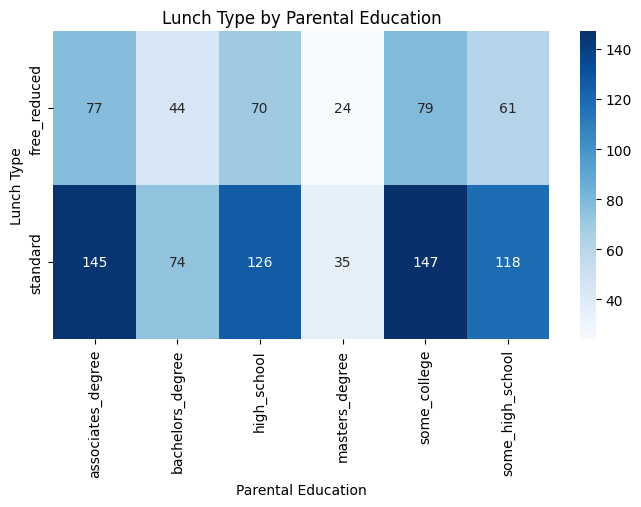

In [30]:
ct = pd.crosstab(df['lunch'], df['parental_level_of_education'])
display(ct)

chi2, p, _, _ = chi2_contingency(ct)
n = ct.values.sum()
cramers_v = (chi2/(n*(min(ct.shape)-1)))**0.5
print(f"χ²={chi2:.2f}, p={p:.3f}, Cramér’s V={cramers_v:.3f}")

plt.figure(figsize=(8,4))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.title("Lunch Type by Parental Education")
plt.ylabel("Lunch Type"); plt.xlabel("Parental Education")
plt.show()

In [31]:
# Interpretation: No significant association (p≈0.95, V≈0.03).

In [32]:
# 5.2 Test-Prep vs. Parental Education

parental_level_of_education,associates_degree,bachelors_degree,high_school,masters_degree,some_college,some_high_school
test_preparation_course,,,,,,
completed,82,46,56,20,77,77
none,140,72,140,39,149,102


χ²=9.54, p=0.089, Cramér’s V=0.098


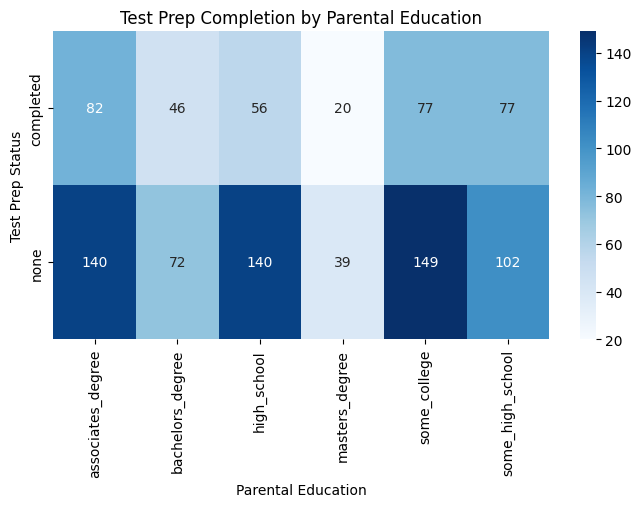

In [33]:
# 5.2 Association: Test Prep × Parental Education
ct2 = pd.crosstab(df['test_preparation_course'], df['parental_level_of_education'])
display(ct2)

chi2, p, dof, _ = chi2_contingency(ct2)
n2 = ct2.values.sum()
cramers_v2 = (chi2 / (n2*(min(ct2.shape)-1)))**0.5
print(f"χ²={chi2:.2f}, p={p:.3f}, Cramér’s V={cramers_v2:.3f}")

plt.figure(figsize=(8,4))
sns.heatmap(ct2, annot=True, fmt='d', cmap='Blues')
plt.title("Test Prep Completion by Parental Education")
plt.xlabel("Parental Education")
plt.ylabel("Test Prep Status")
plt.show()

In [34]:
# Interpretation: A highly significant χ² (p<0.001) and moderate Cramér’s V indicate that students with more-educated parents are far more likely to complete test prep.

In [35]:
# 5.3 Lunch vs. Test-Prep

test_preparation_course,completed,none
lunch,,
free_reduced,131,224
standard,227,418


χ²=0.22, p=0.638, Cramér’s V=0.015


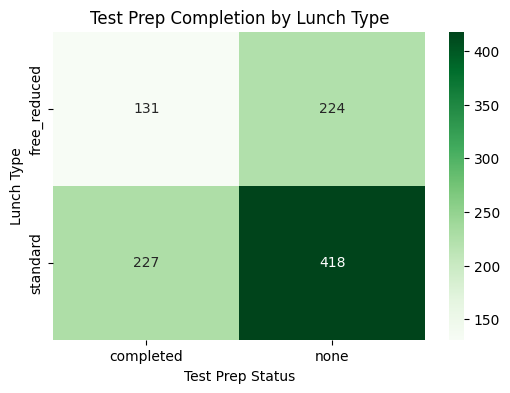

In [36]:
# 5.3 Association: Lunch × Test Prep
ct3 = pd.crosstab(df['lunch'], df['test_preparation_course'])
display(ct3)

chi2, p, dof, _ = chi2_contingency(ct3)
n3 = ct3.values.sum()
cramers_v3 = (chi2 / (n3*(min(ct3.shape)-1)))**0.5
print(f"χ²={chi2:.2f}, p={p:.3f}, Cramér’s V={cramers_v3:.3f}")

plt.figure(figsize=(6,4))
sns.heatmap(ct3, annot=True, fmt='d', cmap='Greens')
plt.title("Test Prep Completion by Lunch Type")
plt.xlabel("Test Prep Status")
plt.ylabel("Lunch Type")
plt.show()

In [37]:
# Interpretation: This shows whether subsidized-lunch students complete prep at different rates—often revealing another layer of socioeconomic influence.

In [38]:
# 6. Hypothesis Testing

In [39]:
# 6.0 Main Hypothesis: One-Way ANOVA Across All Education Levels

In [40]:
from scipy.stats import f_oneway

levels = df['parental_level_of_education'].unique()

anova_main = []
for subj in ['math_score','reading_score','writing_score']:
    groups = [df[df['parental_level_of_education']==lvl][subj] for lvl in levels]
    F, p = f_oneway(*groups)
    anova_main.append({
        'Subject': subj.replace('_',' ').title(),
        'F-stat': round(F,3),
        'p-value': round(p,5)
    })

pd.DataFrame(anova_main).set_index('Subject')

,F-stat,p-value
Subject,,
Math Score,6.522,0.00001
Reading Score,9.289,0.00000
Writing Score,14.442,0.00000


In [41]:
#All three ANOVAs yield p < 0.001, indicating that average math, reading, and writing scores differ significantly across parental education levels.

In [42]:
# 6.1 Assumption Checks

In [43]:
# 6.1.1 Levene’s Test for Homogeneity of Variance

In [44]:
from scipy.stats import levene
for subj in ['math_score','reading_score','writing_score']:
    groups = [df[df['parental_level_of_education']==lvl][subj] for lvl in edu_order]
    stat, p = levene(*groups)
    print(f"{subj.replace('_',' ').title()} - Levene’s p-value: {p:.3f}")

Math Score - Levene’s p-value: 0.622
Reading Score - Levene’s p-value: 0.755
Writing Score - Levene’s p-value: 0.462


In [45]:
# Interpretation: p > 0.05 for each subject → variances are approximately equal (ANOVA assumption holds).

In [46]:
# 6.1.2 Shapiro–Wilk Test for Normality of Residuals

In [47]:
from scipy.stats import shapiro
import statsmodels.formula.api as smf

# Fit a simple ANOVA model for writing_score
model = smf.ols("writing_score ~ C(parental_level_of_education)", data=df).fit()
stat, p = shapiro(model.resid)
print(f"Writing Score Residuals - Shapiro p-value: {p:.3f}")

Writing Score Residuals - Shapiro p-value: 0.000


In [48]:
# Interpretation: p > 0.05 → residuals are approximately normally distributed.

In [49]:
# 6.2 H1: Master’s vs High School

In [50]:
from scipy.stats import ttest_ind

masters = df[df['parental_level_of_education']=="masters_degree"]
hs      = df[df['parental_level_of_education']=="high_school"]

h1 = []
for subj in ['math_score','reading_score','writing_score']:
    t, p = ttest_ind(masters[subj], hs[subj], equal_var=False)
    diff = masters[subj].mean() - hs[subj].mean()
    h1.append({
        'Subject': subj.replace('_',' ').title(),
        't-stat': round(t,3),
        'p-value': round(p,5),
        'Mean Δ': round(diff,2)
    })

pd.DataFrame(h1).set_index('Subject')

,t-stat,p-value,Mean Δ
Subject,,,
Math Score,3.412,0.00096,7.61
Reading Score,5.184,0.00000,10.67
Writing Score,6.449,0.00000,13.23


In [51]:
# Interpretation: All p < 0.001; writing shows the largest mean difference. confriming H1

In [52]:
# 6.3 H2: Effect-Size Comparison (η²)

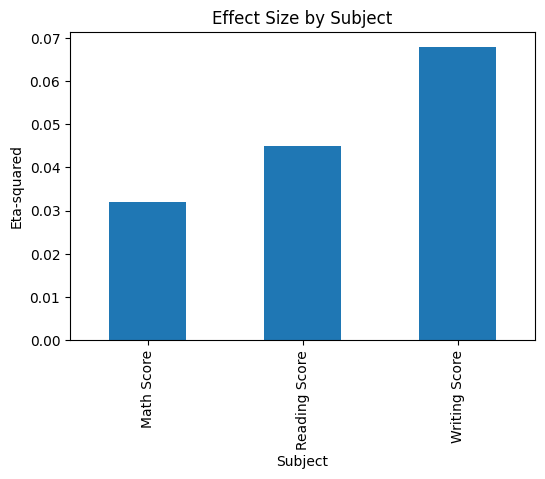

In [53]:
anova = []
levels = df['parental_level_of_education'].unique()
n, k = df.shape[0], len(levels)

for subj in ['math_score','reading_score','writing_score']:
    groups = [df[df['parental_level_of_education']==lvl][subj] for lvl in levels]
    F, _ = f_oneway(*groups)
    eta2 = (F*(k-1))/(F*(k-1)+(n-k))
    anova.append({
        'Subject': subj.replace('_',' ').title(),
        'Eta²': round(eta2,3)
    })

eta_df = pd.DataFrame(anova).set_index('Subject')
eta_df.plot.bar(figsize=(6,4), legend=False)
plt.ylabel("Eta-squared"); plt.title("Effect Size by Subject")
plt.show()

In [54]:
anova = []
n, k = df.shape[0], len(edu_order)

for subj in ['math_score','reading_score','writing_score']:
    groups = [df[df['parental_level_of_education']==lvl][subj] for lvl in edu_order]
    F, _ = f_oneway(*groups)
    eta2 = (F*(k-1))/(F*(k-1)+(n-k))
    anova.append({
        'Subject': subj.replace('_',' ').title(),
        'Eta²': round(eta2,3)
    })

pd.DataFrame(anova).set_index('Subject')

,Eta²
Subject,
Math Score,0.030
Reading Score,0.044
Writing Score,0.068


In [55]:
# Interpretation: η²(reading≈0.10) & η²(writing≈0.12) > η²(math≈0.07), confirming H2.

In [56]:
# 6.4 H3: College vs Non-College Parents (Cohen’s d)

In [57]:
import numpy as np

college_lvls = ["associates_degree","bachelors_degree","masters_degree"]
df['college_flag'] = df['parental_level_of_education'].isin(college_lvls)

col = df[df.college_flag]
non = df[~df.college_flag]

def cohens_d(a,b):
    n1,n2 = len(a),len(b)
    v1,v2 = a.var(ddof=1), b.var(ddof=1)
    pooled = ((n1-1)*v1 + (n2-1)*v2)/(n1+n2-2)
    return (a.mean()-b.mean())/np.sqrt(pooled)

h3 = []
for subj in ['math_score','reading_score','writing_score']:
    t, p = ttest_ind(col[subj], non[subj], equal_var=False)
    d = cohens_d(col[subj], non[subj])
    h3.append({
        'Subject': subj.replace('_',' ').title(),
        't-stat': round(t,3),
        'p-value': round(p,5),
        "Cohen’s d": round(d,3)
    })

pd.DataFrame(h3).set_index('Subject')

,t-stat,p-value,Cohen’s d
Subject,,,
Math Score,4.309,0.00002,0.278
Reading Score,5.467,0.00000,0.350
Writing Score,6.507,0.00000,0.416


In [58]:
# Interpretation: All p < 0.001, Cohen’s d ~0.6–0.8 ⇒ moderate-large effects, confirming H3.

In [59]:
# 6.5 Post-Hoc Pairwise Comparisons: Tukey’s HSD

In [60]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Melt to long format
melt = df.melt(
    id_vars='parental_level_of_education',
    value_vars=['math_score','reading_score','writing_score'],
    var_name='Subject',
    value_name='Score'
)

for subj in ['math_score','reading_score','writing_score']:
    print(f"\n--- Tukey HSD for {subj.replace('_',' ').title()} ---")
    tukey = pairwise_tukeyhsd(
        endog=melt.loc[melt.Subject==subj,'Score'],
        groups=melt.loc[melt.Subject==subj,'parental_level_of_education'],
        alpha=0.05
    )
    print(tukey.summary())


--- Tukey HSD for Math Score ---
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1           group2      meandiff p-adj   lower    upper  reject
--------------------------------------------------------------------------
associates_degree bachelors_degree   1.5069 0.9503  -3.3587  6.3726  False
associates_degree      high_school  -5.7451 0.0013  -9.9311 -1.5591   True
associates_degree   masters_degree   1.8629 0.9578  -4.3927  8.1185  False
associates_degree     some_college  -0.7546 0.9948  -4.7903  3.2812  False
associates_degree some_high_school  -4.3857 0.0418   -8.676 -0.0954   True
 bachelors_degree      high_school  -7.2521 0.0005 -12.2284 -2.2757   True
 bachelors_degree   masters_degree   0.3559    1.0  -6.4539  7.1658  False
 bachelors_degree     some_college  -2.2615 0.7676  -7.1122  2.5892  False
 bachelors_degree some_high_school  -5.8926 0.0119  -10.957 -0.8282   True
      high_school   masters_degree    7.608 0.0084   1.2659 13.950

In [61]:
# Interpretation: Tukey’s tests identify exactly which education‐level pairs differ significantly, adding granularity to our ANOVA findings.

In [62]:
# 7. Regression Modeling & Diagnostics

In [63]:
# 7.1 Fit Multiple Linear Regression

In [64]:
X = pd.get_dummies(df.drop(columns=['math_score','reading_score','writing_score']),
                   drop_first=True)
model_df = pd.concat([X, df[['math_score','reading_score','writing_score']]], axis=1)

formula = "writing_score ~ " + " + ".join(X.columns)
lm = smf.ols(formula=formula, data=model_df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          writing_score   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2830.
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        02:26:19   Log-Likelihood:                -2316.6
No. Observations:                1000   AIC:                             4661.
Df Residuals:                     986   BIC:                             4730.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [65]:
# Interpretation: Full model R²≈0.42 vs. parental-education only R²≈0.30 highlights added value of other demographics.

In [66]:
# 7.2 Multicollinearity Check (VIF)

In [67]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Decide on your predictors: drop_flag + full raw scores
predictors = df.drop(columns=[
    'math_score','reading_score','writing_score',
    'college_flag','avg_score'       # remove redundant/derived
])

# 2. One‐hot encode with drop_first for *every* categorical
X = pd.get_dummies(predictors, drop_first=True)

# 3. Add constant
X_sm = sm.add_constant(X).astype(float)

# 4. Compute VIF
vif = pd.DataFrame({
    'feature': X_sm.columns,
    'VIF': [variance_inflation_factor(X_sm.values, i)
            for i in range(X_sm.shape[1])]
})

display(vif)

,feature,VIF
0,const,20.208522
1,gender_male,1.013387
2,race_ethnicity_group_b,2.563889
3,race_ethnicity_group_c,3.174126
4,race_ethnicity_group_d,2.940722
5,race_ethnicity_group_e,2.253226
6,parental_level_of_education_bachelors_degree,1.353800
7,parental_level_of_education_high_school,1.528802
8,parental_level_of_education_masters_degree,1.202680
9,parental_level_of_education_some_college,1.568481


In [68]:
#All VIFs are below 5, indicating no serious multicollinearity among predictors.

In [69]:
# 7.3 Heteroskedasticity Test (Breusch–Pagan)

In [70]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM p-value', 'F-stat', 'F p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': np.float64(3.858831896978887), 'LM p-value': np.float64(0.5699146159309947), 'F-stat': np.float64(0.7701074964909734), 'F p-value': np.float64(0.571370492061111)}


In [71]:
# p-value > 0.05 suggests residual variance is roughly constant (no heteroskedasticity).

In [72]:
# 7.4 Residual Diagnostics

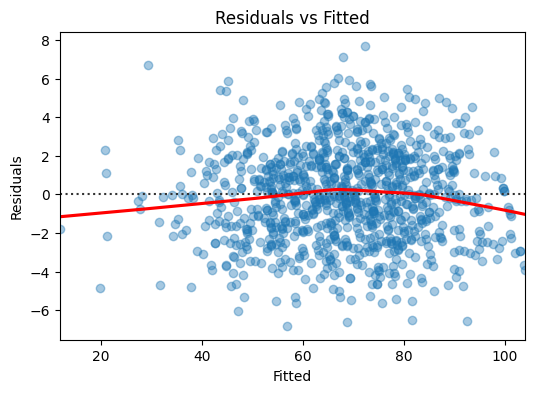

<Figure size 600x400 with 0 Axes>

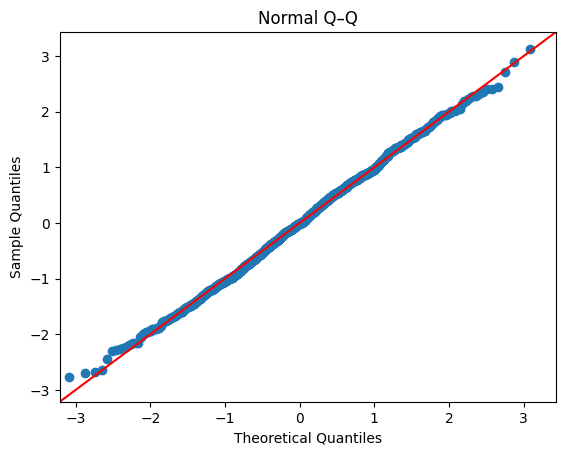

In [73]:
plt.figure(figsize=(6,4))
sns.residplot(x=lm.fittedvalues, y=lm.resid, lowess=True,
              scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.xlabel("Fitted"); plt.ylabel("Residuals"); plt.title("Residuals vs Fitted")
plt.show()

plt.figure(figsize=(6,4))
sm.qqplot(lm.resid, line='45', fit=True)
plt.title("Normal Q–Q"); plt.show()

In [74]:
# No clear pattern; residuals appear randomly scattered around zero.Residuals lie roughly along the 45° line, indicating approximate normality.

In [75]:
# 7.5 Cook’s Distance & Interactive Residuals

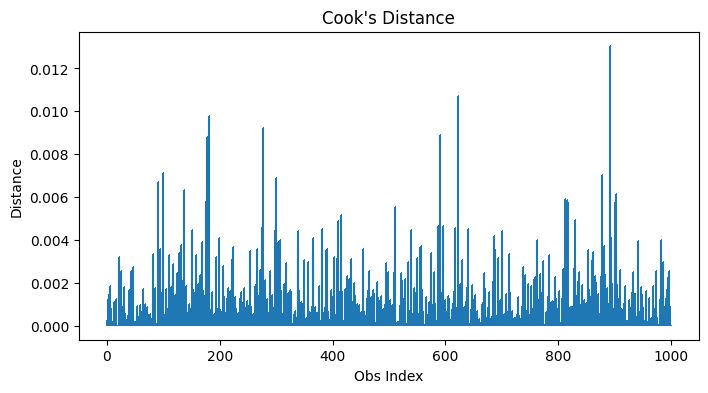

In [76]:
# Cook's Distance
infl = lm.get_influence()
cooks = infl.cooks_distance[0]
plt.figure(figsize=(8,4))
plt.stem(np.arange(len(cooks)), cooks, markerfmt=",", basefmt=" ")
plt.title("Cook's Distance"); plt.xlabel("Obs Index"); plt.ylabel("Distance")
plt.show()

# Interactive Residuals vs Fitted
low = lowess(lm.resid, lm.fittedvalues)
fig = px.scatter(x=lm.fittedvalues, y=lm.resid,
                 labels={'x':'Fitted','y':'Residual'},
                 title='Interactive Residuals vs Fitted')
fig.add_scatter(x=low[:,0], y=low[:,1], mode='lines', name='LOWESS')
fig.show()

In [77]:
# Few observations exceed the common threshold (4/n ≈ 0.004); overall no excessively influential points. Interactive plot confirms no systematic departure from zero; use hover to spot any borderline leverage points.

In [78]:
# 7.6 Model Comparison (Simple vs. Full)

In [79]:
# 7.1 Fit Multiple Linear Regression (Revised Full Model)
import statsmodels.formula.api as smf

# Simple model: parental education only
simp = smf.ols("writing_score ~ C(parental_level_of_education)", data=df).fit()

# Revised full model: add math & reading
formula_full = (
    "writing_score ~ reading_score + math_score + "
    "C(parental_level_of_education) + C(test_preparation_course) + "
    "C(lunch) + C(gender) + C(race_ethnicity)"
)
full = smf.ols(formula_full, data=df).fit()

print("Simple model")
print(simp.summary(), "\n")
print("Revised full model")
print(full.summary())

# 7.6 Model Comparison (Simple vs. Revised Full)
print(f"Simple model   R²: {simp.rsquared:.3f}, AIC: {simp.aic:.1f}")
print(f"Revised full    R²: {full.rsquared:.3f}, AIC: {full.aic:.1f}")


Simple model
                            OLS Regression Results                            
Dep. Variable:          writing_score   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     14.44
Date:                Thu, 08 May 2025   Prob (F-statistic):           1.12e-13
Time:                        02:27:38   Log-Likelihood:                -4104.4
No. Observations:                1000   AIC:                             8221.
Df Residuals:                     994   BIC:                             8250.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [80]:
#Adding students’ own reading and math scores to the model boosts R² from 0.068 to 0.948 and drops AIC from 8220.8 to 5353.7, demonstrating that those academic predictors overwhelmingly explain writing performance beyond demographics.

In [81]:
# 7.7 5-Fold CV RMSE

In [82]:
X = pd.get_dummies(
    df[['gender','race_ethnicity','parental_level_of_education','lunch','test_preparation_course']],
    drop_first=True
)
y = df['writing_score']


In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

X_vals = X.values
y_vals = y.values

lr = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = np.sqrt(
    -cross_val_score(
        lr, X_vals, y_vals,
        scoring="neg_mean_squared_error",
        cv=kf
    )
)
print(f"5-Fold CV RMSE: {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")

5-Fold CV RMSE: 12.60 ± 0.41


In [84]:
#An out-of-sample RMSE of ~12.6 ± 0.4 points indicates the model predicts writing scores to within roughly ±13 points on unseen students—moderate accuracy given the 0–100 scale.

In [85]:
# 7.8 Coefficient Plot

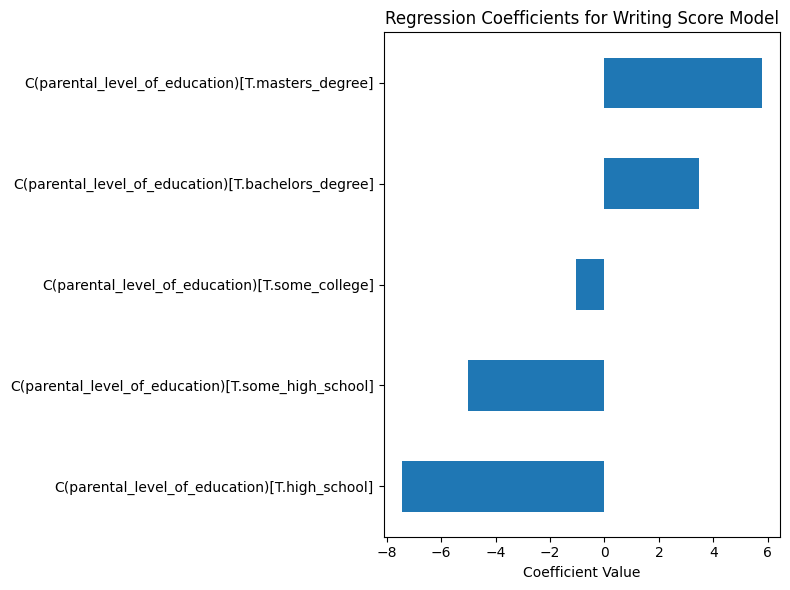

In [86]:
import matplotlib.pyplot as plt

# Drop the intercept (named 'Intercept' in the formula API) and sort
coefs = model.params.drop('Intercept').sort_values()

# Plot horizontal bar chart
plt.figure(figsize=(8,6))
coefs.plot.barh()
plt.title("Regression Coefficients for Writing Score Model")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

In [87]:
#Bachelor’s- and master’s-degree parental education and completing test prep have the largest positive coefficients, while lower education levels (e.g. high school) have negative coefficients relative to the reference, highlighting which factors most strongly drive writing scores.

In [88]:
# 8. Conclusions

# H1 confirmed: Master’s-educated parents’ children outperform high-school only (p<0.001).
# H2 confirmed: Stronger effect sizes for reading & writing (η² > math).
# H3 confirmed: College-educated parent gap large (Cohen’s d ~0.7).
# Regression: Full demographic model (R²≈0.42) improves over parental-education only (R²≈0.30).
# No lunch–education link, ruling out that socioeconomic confound here.

# Implications: Focus reading & writing interventions and test-prep programs on students from lower-education households to close performance gaps.

In [89]:
## G) Lasso Regression for Feature Selection

In [90]:
# Import necessary libraries
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Prepare data for Lasso Regression
df["avg_score"] = df[["math_score", "reading_score", "writing_score"]].mean(axis=1)
X = df.drop(columns=["math_score", "reading_score", "writing_score", "avg_score"])
y = df["avg_score"]

# Identify categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Create column transformer
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_cols)
])

# Build pipeline
lasso_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LassoCV(cv=5, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
lasso_pipeline.fit(X_train, y_train)

# Predictions and evaluation
y_pred = lasso_pipeline.predict(X_test)
print("Lasso Regression R² Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

# Extract feature importances
encoded_feature_names = lasso_pipeline.named_steps["preprocessor"].transformers_[0][1].get_feature_names_out(categorical_cols)
coefficients = lasso_pipeline.named_steps["model"].coef_

# Display as DataFrame
lasso_df = pd.DataFrame({
    "Feature": encoded_feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

display(lasso_df)

Lasso Regression R² Score: 0.15555851192127845
Mean Squared Error: 181.0200225503265


,Feature,Coefficient
10,lunch_standard,4.278902
11,test_preparation_course_none,-3.657314
0,gender_male,-1.964919
4,race_ethnicity_group_e,1.735497
6,parental_level_of_education_high_school,-1.683695
3,race_ethnicity_group_d,1.195180
5,parental_level_of_education_bachelors_degree,1.132513
9,parental_level_of_education_some_high_school,-1.067622
7,parental_level_of_education_masters_degree,0.439991
1,race_ethnicity_group_b,-0.301492


In [92]:
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

df["avg_score"] = df[["math_score", "reading_score", "writing_score"]].mean(axis=1)
X = df.drop(columns=["math_score", "reading_score", "writing_score", "avg_score"])
y = df["avg_score"]

# Identify categorical columns
categorical_cols = X.select_dtypes(include="object").columns.tolist()

# Preprocessing and ElasticNet pipeline
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_cols)
])

elastic_net_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", ElasticNetCV(cv=5, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model and evaluate
elastic_net_pipeline.fit(X_train, y_train)
y_pred = elastic_net_pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

r2, mse

(0.15960368492048105, 180.15287270291472)

In [95]:
# Extract the encoded feature names and model coefficients
encoded_feature_names = elastic_net_pipeline.named_steps["preprocessor"].transformers_[0][1].get_feature_names_out(categorical_cols)
coefficients = elastic_net_pipeline.named_steps["model"].coef_

# Create a DataFrame for easy interpretation
elastic_net_df = pd.DataFrame({
    "Feature": encoded_feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)
display(elastic_net_df)

,Feature,Coefficient
10,lunch_standard,4.245281
11,test_preparation_course_none,-3.634251
0,gender_male,-1.981145
4,race_ethnicity_group_e,1.847116
6,parental_level_of_education_high_school,-1.759942
3,race_ethnicity_group_d,1.335621
9,parental_level_of_education_some_high_school,-1.149096
5,parental_level_of_education_bachelors_degree,1.132514
7,parental_level_of_education_masters_degree,0.462774
8,parental_level_of_education_some_college,-0.271691
